In [3]:

import os
import numpy as np
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import yaml

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


In [5]:
# Load configuration from YAML file
def load_config(config_path='config.yaml'):
    """Load configuration from YAML file."""
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        print(f"✅ Configuration loaded from {config_path}")
        return config
    except FileNotFoundError:
        print(f"⚠️  {config_path} not found, using default values")
        return get_default_config()
    except Exception as e:
        print(f"❌ Error loading config: {e}")
        return get_default_config()

def get_default_config():
    """Return default configuration values."""
    return {
        'paths': {
            'model_save_dir': 'models/',
            'results_dir': 'inference_results/'
        },
        'dataset': {
            'image_size': 256
        },
        'model': {
            'input_channels': 3,
            'output_channels': 1,
            'base_features': 64,
            'use_bilinear': True
        },
        'whitening': {
            'lightness_increase': 40,
            'yellowness_decrease': 25,
            'blur_kernel_size': [21, 21],
            'mask_threshold': 127
        }
    }

# Load configuration
config = load_config()

# Extract configuration values
MODEL_SAVE_DIR = config['paths']['model_save_dir']
RESULTS_DIR = config['paths']['results_dir']
IMAGE_SIZE = config['dataset']['image_size']
INPUT_CHANNELS = config['model']['input_channels']
OUTPUT_CHANNELS = config['model']['output_channels']
BASE_FEATURES = config['model']['base_features']
USE_BILINEAR = config['model']['use_bilinear']
BASE_CHANNELS = config['model'].get('base_channesls', 48)
DEPTH = config['model'].get('depth', 4)
LIGHTNESS_INCREASE = config['whitening']['lightness_increase']
YELLOWNESS_DECREASE = config['whitening']['yellowness_decrease']
BLUR_KERNEL_SIZE = tuple(config['whitening']['blur_kernel_size'])
MASK_THRESHOLD = config['whitening']['mask_threshold']

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {DEVICE}")

# Create output directory
os.makedirs(RESULTS_DIR, exist_ok=True)

✅ Configuration loaded from config.yaml
🔧 Using device: cpu


In [6]:
class DoubleConv(nn.Module):
    """Double convolution with BatchNorm and ReLU"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downsampling: MaxPool -> DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class AttentionGate(nn.Module):
    """Attention Gate for focusing on relevant features"""

    def __init__(self, gate_channels, skip_channels, inter_channels):
        super().__init__()
        self.W_gate = nn.Sequential(
            nn.Conv2d(gate_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.W_skip = nn.Sequential(
            nn.Conv2d(skip_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip):
        """
        gate: gating signal from coarser scale (decoder)
        skip: skip connection from encoder
        """
        # Resize gate to match skip dimensions if needed
        gate_size = skip.size()[2:]
        gate_resized = F.interpolate(gate, size=gate_size, mode='bilinear', align_corners=True)

        # Apply transformations
        g1 = self.W_gate(gate_resized)
        x1 = self.W_skip(skip)

        # Attention computation
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        # Apply attention to skip connection
        return skip * psi


class AttentionUp(nn.Module):
    """Fixed Upsampling with Attention Gate"""

    def __init__(self, in_channels, skip_channels, out_channels, bilinear=True):
        super().__init__()

        # Upsampling
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Reduce channels after upsampling
            self.up_conv = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
            up_out_ch = in_channels // 2
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.up_conv = None
            up_out_ch = in_channels // 2

        # Attention Gate - FIXED channel dimensions
        self.attention = AttentionGate(
            gate_channels=up_out_ch,        # From upsampled features
            skip_channels=skip_channels,     # From encoder skip connection
            inter_channels=min(up_out_ch, skip_channels) // 2  # Conservative inter channels
        )

        # Final convolution - FIXED input channel calculation
        total_channels = up_out_ch + skip_channels
        self.conv = DoubleConv(total_channels, out_channels)

    def forward(self, x1, x2):
        """
        x1: features from decoder (gating signal)
        x2: features from encoder (skip connection)
        """
        # Upsample x1
        x1 = self.up(x1)
        if self.up_conv is not None:
            x1 = self.up_conv(x1)

        # Handle size differences
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        # Apply attention to skip connection
        x2_attended = self.attention(x1, x2)

        # Concatenate and process
        x = torch.cat([x2_attended, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Output convolution"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class CompactAttentionUNet(nn.Module):
    """Fixed Compact Attention U-Net optimized for teeth segmentation """

    def __init__(self, n_channels=3, n_classes=1, bilinear=True, base_channels=48, depth=4):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_channels = base_channels
        self.depth = depth

        # Input convolution
        self.inc = DoubleConv(n_channels, base_channels)

        # Build encoder layers dynamically
        self.down_layers = nn.ModuleList()
        channel_multipliers = self._get_channel_multipliers()

        for i in range(depth):
            in_ch = base_channels * channel_multipliers[i]
            out_ch = base_channels * channel_multipliers[i + 1]
            self.down_layers.append(Down(in_ch, out_ch))

        # Build FIXED attention decoder layers
        self.attention_up_layers = nn.ModuleList()

        # Calculate decoder channels correctly
        for i in range(depth):
            # Current decoder level (from bottom to top)
            decoder_level = depth - 1 - i

            if i == 0:  # First decoder layer (bottom)
                # Input from bottleneck
                in_ch = base_channels * channel_multipliers[depth]
                # Skip from encoder level depth-1
                skip_ch = base_channels * channel_multipliers[depth - 1]
                # Output channels
                out_ch = skip_ch
            else:
                # Input from previous decoder layer
                in_ch = base_channels * channel_multipliers[depth - i]
                # Skip from encoder
                skip_ch = base_channels * channel_multipliers[decoder_level]
                # Output channels
                if decoder_level == 0:  # Final level
                    out_ch = base_channels
                else:
                    out_ch = skip_ch

            self.attention_up_layers.append(
                AttentionUp(in_ch, skip_ch, out_ch, bilinear)
            )

        # Output convolution
        self.outc = OutConv(base_channels, n_classes)

        # Print architecture details
        self._print_architecture_info(channel_multipliers)

    def _get_channel_multipliers(self):
        """Optimized channel multipliers for <200MB constraint"""
        if self.depth == 4:
            # Reduced multipliers for teeth segmentation efficiency
            return [1, 2, 4, 6, 6]  # Max 288 channels instead of 512
        elif self.depth == 3:
            return [1, 2, 4, 4]
        elif self.depth == 5:
            return [1, 2, 3, 4, 5, 5]  # Conservative growth
        else:
            # Conservative progression for memory efficiency
            multipliers = [1]
            for i in range(self.depth):
                if i < 2:
                    multipliers.append(multipliers[-1] * 2)
                else:
                    multipliers.append(multipliers[-1] + 1)  # Linear growth
            multipliers.append(multipliers[-1])  # Bottleneck same as last
            return multipliers

    def _print_architecture_info(self, channel_multipliers):
        """Print architecture information for teeth segmentation"""
        print(f"🦷 FIXED Compact Attention U-Net for Teeth Segmentation (Depth {self.depth}):")
        print(f"   Base channels: {self.base_channels}")
        print(f"   Bilinear: {self.bilinear}")

        # Show encoder progression
        encoder_channels = [self.base_channels * mult for mult in channel_multipliers]
        print(f"   Encoder: {' -> '.join(map(str, encoder_channels))}")

        # Show fixed decoder details
        print(f"   🔧 FIXED Attention Decoder:")
        for i, up_layer in enumerate(self.attention_up_layers):
            level = self.depth - 1 - i
            print(f"     AttUp{i+1}: Level {level} -> Fixed channel alignment")

    def forward(self, x):
        # Initial convolution
        x_current = self.inc(x)

        # Store skip connections
        skip_connections = [x_current]

        # Encoder path
        for down_layer in self.down_layers:
            x_current = down_layer(x_current)
            skip_connections.append(x_current)

        # Start decoder with bottleneck
        x = skip_connections.pop()

        # Attention decoder path
        for attention_up_layer in self.attention_up_layers:
            skip = skip_connections.pop()
            x = attention_up_layer(x, skip)  # x is gate, skip is skip connection

        # Output convolution
        return self.outc(x)


def calculate_model_parameters(model):
    """Calculate model parameters and attention gate parameters separately"""
    total_params = 0
    attention_params = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count

        # Count attention gate parameters
        if 'attention' in name:
            attention_params += param_count

    return total_params, attention_params


def debug_model_architecture(model, input_shape=(1, 3, 256, 256)):
    """Debug function to trace tensor shapes through the network"""
    device = next(model.parameters()).device

    print("\n🔍 DEBUGGING MODEL ARCHITECTURE:")
    print("="*60)

    with torch.no_grad():
        x = torch.randn(*input_shape).to(device)
        print(f"Input: {x.shape}")

        # Initial convolution
        x_current = model.inc(x)
        print(f"After inc: {x_current.shape}")

        # Store skip connections and trace encoder
        skip_connections = [x_current]
        print("\nENCODER PATH:")

        for i, down_layer in enumerate(model.down_layers):
            x_current = down_layer(x_current)
            skip_connections.append(x_current)
            print(f"  Down{i+1}: {x_current.shape}")

        print(f"\nBottleneck: {x_current.shape}")

        # Start decoder
        x = skip_connections.pop()
        print(f"Starting decoder with: {x.shape}")

        print("\nDECODER PATH:")
        # Attention decoder path
        for i, attention_up_layer in enumerate(model.attention_up_layers):
            skip = skip_connections.pop()
            print(f"  AttUp{i+1}:")
            print(f"    Gate input: {x.shape}")
            print(f"    Skip input: {skip.shape}")

            try:
                x = attention_up_layer(x, skip)
                print(f"    Output: {x.shape}")
            except Exception as e:
                print(f"    ❌ ERROR: {e}")
                # Print attention gate channel info
                att_gate = attention_up_layer.attention
                print(f"    Debug - Gate conv expects: {att_gate.W_gate[0].in_channels} channels")
                print(f"    Debug - Skip conv expects: {att_gate.W_skip[0].in_channels} channels")
                return False

        # Output convolution
        final_output = model.outc(x)
        print(f"\nFinal output: {final_output.shape}")
        print("✅ Architecture debug completed successfully!")
        return True


# Configuration for teeth segmentation
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1
USE_BILINEAR = True
BASE_CHANNELS = 48
DEPTH = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize FIXED model
print("🚀 Creating FIXED Compact Attention U-Net...")
model = CompactAttentionUNet(
    n_channels=INPUT_CHANNELS,
    n_classes=OUTPUT_CHANNELS,
    bilinear=USE_BILINEAR,
    base_channels=BASE_CHANNELS,
    depth=DEPTH
).to(DEVICE)

🚀 Creating FIXED Compact Attention U-Net...
🦷 FIXED Compact Attention U-Net for Teeth Segmentation (Depth 4):
   Base channels: 48
   Bilinear: True
   Encoder: 48 -> 96 -> 192 -> 288 -> 288
   🔧 FIXED Attention Decoder:
     AttUp1: Level 3 -> Fixed channel alignment
     AttUp2: Level 2 -> Fixed channel alignment
     AttUp3: Level 1 -> Fixed channel alignment
     AttUp4: Level 0 -> Fixed channel alignment


In [7]:
class TeethWhitener:
    """Advanced teeth whitening using LAB color space."""

    def __init__(self, lightness_increase=40, yellowness_decrease=25,
                 blur_kernel=(21, 21), mask_threshold=127):
        """
        Initialize whitening parameters.

        Args:
            lightness_increase: How much to increase L channel (brightness)
            yellowness_decrease: How much to decrease B channel (yellow)
            blur_kernel: Kernel size for mask feathering
            mask_threshold: Threshold for mask binarization
        """
        self.lightness_increase = lightness_increase
        self.yellowness_decrease = yellowness_decrease
        self.blur_kernel = blur_kernel
        self.mask_threshold = mask_threshold

    def preprocess_mask(self, mask):
        """Clean and prepare mask for whitening."""
        # Convert to grayscale if needed
        if len(mask.shape) == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # Ensure proper range
        if mask.max() <= 1.0:
            mask = (mask * 255).astype(np.uint8)

        # Apply threshold
        _, binary_mask = cv2.threshold(mask, self.mask_threshold, 255, cv2.THRESH_BINARY)

        # Clean up mask with morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)  # Remove noise
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)  # Fill holes

        return binary_mask

    def create_feathered_mask(self, binary_mask):
        """Create soft-edged mask for natural blending."""
        # Apply Gaussian blur for soft edges
        feathered = cv2.GaussianBlur(binary_mask, self.blur_kernel, 0)

        # Normalize to [0, 1] range
        feathered = feathered.astype(np.float32) / 255.0

        # Apply gamma correction for more natural falloff
        feathered = np.power(feathered, 1.2)

        return feathered

    def analyze_teeth_color(self, image, mask):
        """Analyze teeth color properties for adaptive whitening."""
        # Convert to LAB color space
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

        # Extract teeth pixels
        teeth_pixels = lab_image[mask > 0]

        if len(teeth_pixels) == 0:
            return {'avg_lightness': 128, 'yellowness_level': 0.5}

        # Calculate average lightness and yellowness
        avg_l = np.mean(teeth_pixels[:, 0])  # L channel (lightness)
        avg_b = np.mean(teeth_pixels[:, 2])  # B channel (blue-yellow)

        # Calculate yellowness level (higher B = more yellow)
        yellowness_level = max(0, (avg_b - 128) / 128.0)

        return {
            'avg_lightness': avg_l,
            'yellowness_level': yellowness_level
        }

    def get_adaptive_parameters(self, color_analysis):
        """Calculate adaptive whitening parameters."""
        # Adaptive lightness: darker teeth get more brightening
        lightness_factor = max(0.3, min(1.5, (255 - color_analysis['avg_lightness']) / 100))
        adaptive_lightness = self.lightness_increase * lightness_factor

        # Adaptive yellowness: more yellow teeth get stronger reduction
        yellowness_factor = max(0.2, min(2.0, color_analysis['yellowness_level'] + 0.5))
        adaptive_yellowness = self.yellowness_decrease * yellowness_factor

        # Keep within reasonable bounds
        adaptive_lightness = np.clip(adaptive_lightness, 10, 80)
        adaptive_yellowness = np.clip(adaptive_yellowness, 5, 50)

        return {
            'lightness_increase': adaptive_lightness,
            'yellowness_decrease': adaptive_yellowness
        }

    def whiten_teeth(self, image, mask, adaptive=True, intensity=1.0):
        """
        Apply teeth whitening to image.

        Args:
            image: Input image (BGR format)
            mask: Segmentation mask
            adaptive: Use adaptive parameters based on teeth color
            intensity: Whitening intensity multiplier (0.0 to 2.0)

        Returns:
            Whitened image (BGR format)
        """
        # Validate inputs
        if image is None or mask is None:
            return image

        if image.shape[:2] != mask.shape[:2]:
            print(f"⚠️  Size mismatch: image {image.shape[:2]} vs mask {mask.shape[:2]}")
            return image

        # Preprocess mask
        binary_mask = self.preprocess_mask(mask)

        # Skip if no teeth detected
        if np.sum(binary_mask) == 0:
            print("⚠️  No teeth detected in mask")
            return image

        # Determine whitening parameters
        if adaptive:
            color_analysis = self.analyze_teeth_color(image, binary_mask)
            params = self.get_adaptive_parameters(color_analysis)
            lightness_adj = params['lightness_increase'] * intensity
            yellowness_adj = params['yellowness_decrease'] * intensity
        else:
            lightness_adj = self.lightness_increase * intensity
            yellowness_adj = self.yellowness_decrease * intensity

        # Convert to LAB color space
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        # Apply whitening adjustments
        l_whitened = cv2.add(l_channel, int(lightness_adj), mask=binary_mask)  # Brighter
        b_whitened = cv2.subtract(b_channel, int(yellowness_adj), mask=binary_mask)  # Less yellow

        # Reconstruct LAB image
        whitened_lab = cv2.merge([l_whitened, a_channel, b_whitened])
        whitened_bgr = cv2.cvtColor(whitened_lab, cv2.COLOR_LAB2BGR)

        # Create feathered mask for smooth blending
        feathered_mask = self.create_feathered_mask(binary_mask)
        blend_mask = cv2.cvtColor(feathered_mask, cv2.COLOR_GRAY2BGR)

        # Blend original and whitened images
        final_image = (
            image.astype(np.float32) * (1.0 - blend_mask) +
            whitened_bgr.astype(np.float32) * blend_mask
        ).astype(np.uint8)

        return final_image


# Initialize whitener
teeth_whitener = TeethWhitener(
    lightness_increase=LIGHTNESS_INCREASE,
    yellowness_decrease=YELLOWNESS_DECREASE,
    blur_kernel=BLUR_KERNEL_SIZE,
    mask_threshold=MASK_THRESHOLD
)

print("✅ Teeth whitening algorithm initialized")
print(f"   Lightness increase: {LIGHTNESS_INCREASE}")
print(f"   Yellowness decrease: {YELLOWNESS_DECREASE}")
print(f"   Blur kernel: {BLUR_KERNEL_SIZE}")

✅ Teeth whitening algorithm initialized
   Lightness increase: 40
   Yellowness decrease: 25
   Blur kernel: (21, 21)


In [8]:
class TeethWhiteningPipeline:
    """Complete end-to-end teeth whitening pipeline."""

    def __init__(self, model, whitener, device):
        """
        Initialize pipeline.

        Args:
            model: Trained segmentation model
            whitener: Teeth whitening algorithm
            device: Device to run inference on
        """
        self.model = model
        self.whitener = whitener
        self.device = device

        # Set model to evaluation mode
        self.model.eval()

        # Define preprocessing transform
        self.preprocess = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def load_image(self, image_path):
        """Load image from file path."""
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"❌ Failed to load: {image_path}")
                return None
            return image
        except Exception as e:
            print(f"❌ Error loading {image_path}: {e}")
            return None

    def predict_mask(self, image):
        """Generate segmentation mask for teeth."""
        try:
            # Convert BGR to RGB for PIL
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(rgb_image)

            # Preprocess
            input_tensor = self.preprocess(pil_image).unsqueeze(0).to(self.device)

            # Run inference
            with torch.no_grad():
                logits = self.model(input_tensor)
                probs = torch.sigmoid(logits)
                binary_mask = (probs > 0.5).float()

                # Convert back to numpy
                mask_tensor = binary_mask.squeeze(0).squeeze(0).cpu()
                mask_pil = transforms.ToPILImage()(mask_tensor)

                # Resize to original size
                original_size = (image.shape[1], image.shape[0])  # (width, height)
                mask_resized = mask_pil.resize(original_size, Image.NEAREST)

                return np.array(mask_resized, dtype=np.uint8)

        except Exception as e:
            print(f"❌ Error predicting mask: {e}")
            return None

    def process_single_image(self, image_path, save_path=None,
                           adaptive_whitening=True, intensity=1.0):
        """
        Process single image through complete pipeline.

        Args:
            image_path: Path to input image
            save_path: Path to save result (optional)
            adaptive_whitening: Use adaptive whitening
            intensity: Whitening intensity

        Returns:
            Dictionary with results
        """
        result = {
            'success': False,
            'image_path': image_path,
            'original_image': None,
            'predicted_mask': None,
            'whitened_image': None,
            'error': None
        }

        try:
            # Load image
            original_image = self.load_image(image_path)
            if original_image is None:
                result['error'] = "Failed to load image"
                return result

            result['original_image'] = original_image

            # Predict mask
            predicted_mask = self.predict_mask(original_image)
            if predicted_mask is None:
                result['error'] = "Failed to predict mask"
                return result

            result['predicted_mask'] = predicted_mask

            # Apply whitening
            whitened_image = self.whitener.whiten_teeth(
                original_image, predicted_mask, adaptive_whitening, intensity
            )

            result['whitened_image'] = whitened_image

            # Save if path provided
            if save_path:
                success = cv2.imwrite(save_path, whitened_image)
                if not success:
                    result['error'] = f"Failed to save to {save_path}"
                    return result

            result['success'] = True
            return result

        except Exception as e:
            result['error'] = str(e)
            return result

    def process_directory(self, input_dir, output_dir, max_images=None):
        """
        Process all images in a directory.

        Args:
            input_dir: Input directory with images
            output_dir: Output directory for results
            max_images: Maximum number of images to process

        Returns:
            Dictionary with processing results
        """
        print(f"🔄 Processing directory: {input_dir}")
        print(f"📁 Output directory: {output_dir}")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Get image files
        image_files = [
            f for f in os.listdir(input_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
        ]

        if max_images:
            image_files = image_files[:max_images]

        print(f"📊 Found {len(image_files)} images to process")

        results = {
            'total': len(image_files),
            'successful': 0,
            'failed': 0,
            'samples': []  # Store first few for visualization
        }

        # Process each image
        for filename in tqdm(image_files, desc="Processing images"):
            input_path = os.path.join(input_dir, filename)

            # Generate output filename
            name, ext = os.path.splitext(filename)
            output_filename = f"whitened_{name}{ext}"
            output_path = os.path.join(output_dir, output_filename)

            # Process image
            result = self.process_single_image(input_path, output_path)

            if result['success']:
                results['successful'] += 1
                # Store first few samples for visualization
                if len(results['samples']) < 3:
                    results['samples'].append(result)
            else:
                results['failed'] += 1
                print(f"⚠️  Failed: {filename} - {result['error']}")

        print(f"\n✅ Processing complete:")
        print(f"   Successful: {results['successful']} images")
        print(f"   Failed: {results['failed']} images")

        return results

    def visualize_results(self, results, num_samples=3):
        """Visualize processing results."""
        samples = results.get('samples', [])

        if not samples:
            print("⚠️  No samples to visualize")
            return

        num_samples = min(num_samples, len(samples))

        for i in range(num_samples):
            sample = samples[i]

            # Convert BGR to RGB for matplotlib
            original_rgb = cv2.cvtColor(sample['original_image'], cv2.COLOR_BGR2RGB)
            whitened_rgb = cv2.cvtColor(sample['whitened_image'], cv2.COLOR_BGR2RGB)

            # Create visualization
            plt.figure(figsize=(15, 5))

            # Original
            plt.subplot(1, 3, 1)
            plt.imshow(original_rgb)
            plt.title('Original Image', fontsize=14)
            plt.axis('off')

            # Mask
            plt.subplot(1, 3, 2)
            plt.imshow(sample['predicted_mask'], cmap='gray')
            plt.title('Predicted Teeth Mask', fontsize=14)
            plt.axis('off')

            # Whitened
            plt.subplot(1, 3, 3)
            plt.imshow(whitened_rgb)
            plt.title('Whitened Result', fontsize=14)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            filename = os.path.basename(sample['image_path'])
            print(f"📷 Sample {i+1}: {filename}")
            print("-" * 50)


# Initialize pipeline
pipeline = TeethWhiteningPipeline(
    model=model,
    whitener=teeth_whitener,
    device=DEVICE
)

print("🚀 Complete teeth whitening pipeline initialized!")
print("   ✅ Model ready for inference")
print("   ✅ Whitening algorithm configured")
print("   ✅ Pipeline ready for processing")

🚀 Complete teeth whitening pipeline initialized!
   ✅ Model ready for inference
   ✅ Whitening algorithm configured
   ✅ Pipeline ready for processing


In [9]:
# Load trained model (if available)
print("📥 Loading trained model...")

try:
    best_model_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')

    if os.path.exists(best_model_path):
        # Load checkpoint
        checkpoint = torch.load(best_model_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Get metrics
        metrics = checkpoint.get('metrics', {})
        epoch = checkpoint.get('epoch', 'Unknown')

        print(f"✅ Model loaded successfully!")
        print(f"   Epoch: {epoch}")
        print(f"   Validation Loss: {metrics.get('loss', 'Unknown'):.4f}")
        print(f"   Validation Dice: {metrics.get('dice', 'Unknown'):.4f}")
        print(f"   Validation IoU: {metrics.get('iou', 'Unknown'):.4f}")

        model_loaded = True
    else:
        print(f"⚠️  No trained model found at {best_model_path}")
        print("   Please run training first or provide a pre-trained model")
        model_loaded = False

except Exception as e:
    print(f"❌ Error loading model: {e}")
    model_loaded = False

📥 Loading trained model...
✅ Model loaded successfully!
   Epoch: 5
   Validation Loss: 0.2818
   Validation Dice: 0.8993
   Validation IoU: 0.8173



🔄 Processing test images...
🔄 Processing directory: content\processed_data\processed_data\test\images
📁 Output directory: test_results/
📊 Found 10 images to process


Processing images: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]



✅ Processing complete:
   Successful: 10 images
   Failed: 0 images

📊 Results Summary:
   Total images: 10
   Successful: 10
   Failed: 0

🖼️  Visualizing sample results...


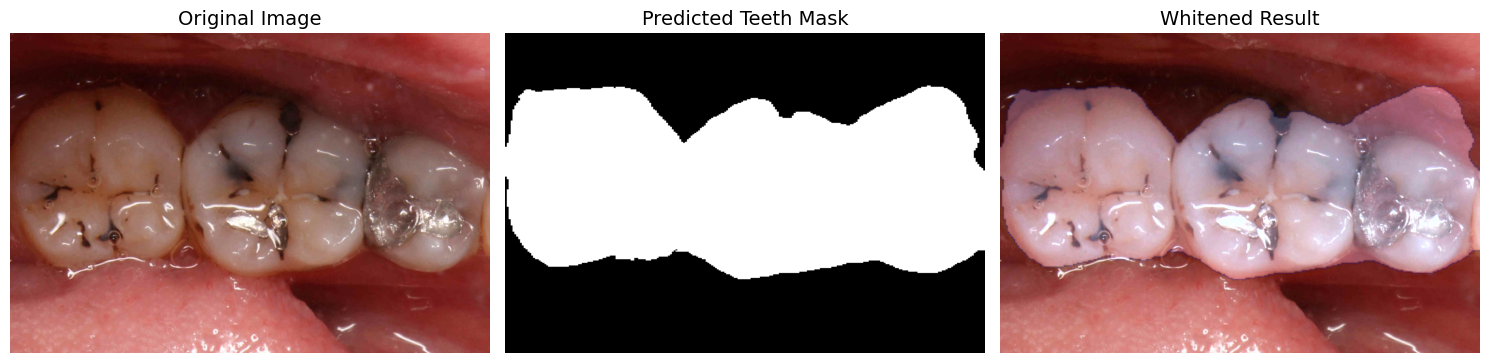

📷 Sample 1: test_0001.jpg
--------------------------------------------------


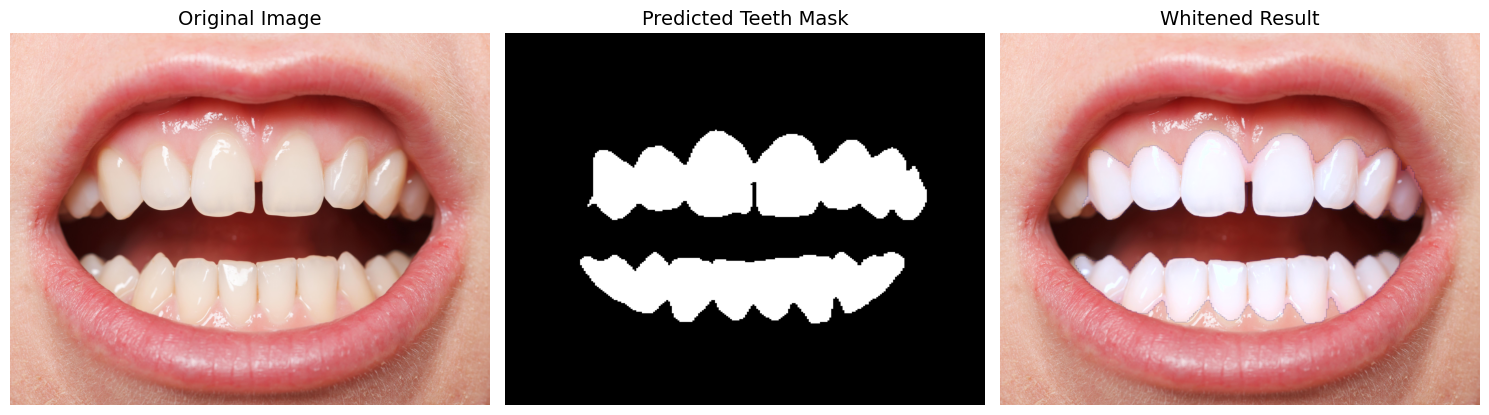

📷 Sample 2: test_0002.jpg
--------------------------------------------------


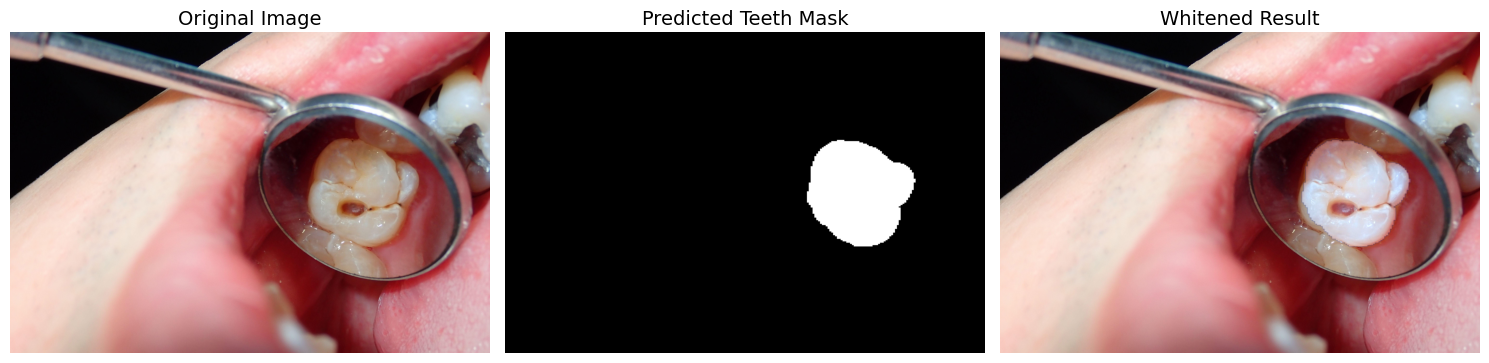

📷 Sample 3: test_0003.jpg
--------------------------------------------------


In [10]:
# Process test images (if model is loaded)
if model_loaded:
    print("\n🔄 Processing test images...")

    # Define paths
    test_input_dir = os.path.join(BASE_DATA_PATH, 'test', 'images')

    if os.path.exists(test_input_dir):
        # Process subset of test images
        batch_results = pipeline.process_directory(
            input_dir=test_input_dir,
            output_dir=RESULTS_DIR,
            max_images=10  # Limit for demonstration
        )

        # Show results summary
        print(f"\n📊 Results Summary:")
        print(f"   Total images: {batch_results['total']}")
        print(f"   Successful: {batch_results['successful']}")
        print(f"   Failed: {batch_results['failed']}")

        # Visualize sample results
        if batch_results['samples']:
            print(f"\n🖼️  Visualizing sample results...")
            pipeline.visualize_results(batch_results, num_samples=3)

    else:
        print(f"⚠️  Test directory not found: {test_input_dir}")
        print("   Please ensure dataset is properly extracted")

else:
    print("⚠️  Cannot process images - no trained model available")
    print("   Please run training first or load a pre-trained model")

Processing: content/processed_data/processed_data/test/images/test_0027.jpg
✅ Success! Result saved to: test_results/whitened_singe_test_test_0027.jpg


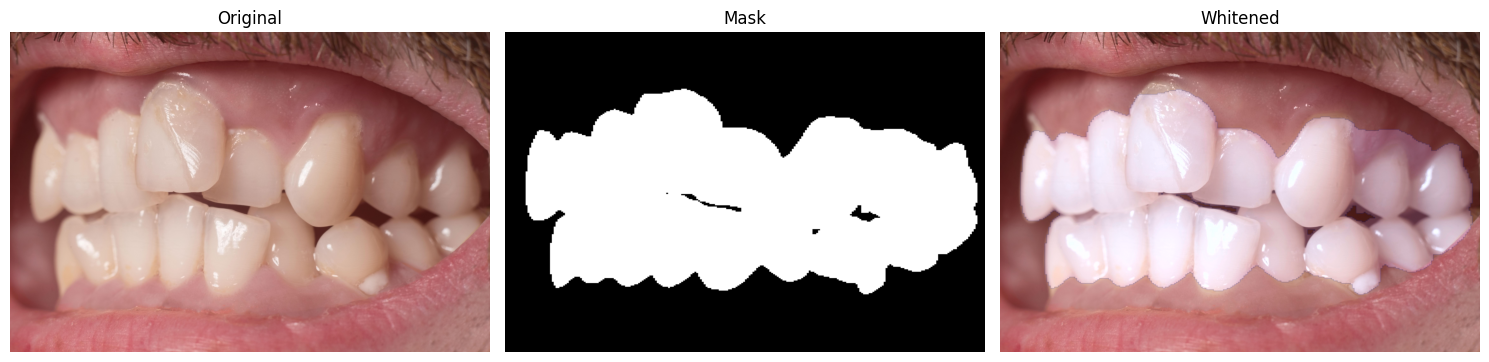

In [11]:


IMAGE_PATH = "content/processed_data/processed_data/test/images/test_0027.jpg" 
OUTPUT_PATH = f"test_results/whitened_singe_test_{IMAGE_PATH.split('/')[-1]}"  

if model_loaded and os.path.exists(IMAGE_PATH):
    print(f"Processing: {IMAGE_PATH}")

    result = pipeline.process_single_image(
        image_path=IMAGE_PATH,
        save_path=OUTPUT_PATH,
        adaptive_whitening=True,
        intensity=1.0
    )

    if result['success']:
        print(f"✅ Success! Result saved to: {OUTPUT_PATH}")

        # Visualize result
        original_rgb = cv2.cvtColor(result['original_image'], cv2.COLOR_BGR2RGB)
        whitened_rgb = cv2.cvtColor(result['whitened_image'], cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(original_rgb)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(result['predicted_mask'], cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(whitened_rgb)
        plt.title('Whitened')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ Failed: {result['error']}")
else:
    print("⚠️  Please update IMAGE_PATH with a valid image path")

